### Import Libraries

In [127]:
from grafo import Grafo
import pandas as pd
import numpy as np
import tsp_solver.greedy as tsp_greedy
from python_tsp.exact import solve_tsp_dynamic_programming as tsp_full

### Load Data

In [106]:
cruces = pd.read_csv("data/cruces_clean.csv")
direcciones = pd.read_csv("data/direcciones_clean.csv")

### Exploration

In [107]:
cruces

,id_via,nombre_via,id_via_cruzada,nombre_via_cruzada,tipo_via,x,y
0,127,CALLE DE ISABEL COLBRAND,2792,CALLE DE CASTIELLO DE JACA,CALLE,44260746,448479753
1,127,CALLE DE ISABEL COLBRAND,1837,CALLE DE FEDERICO MOMPOU,CALLE,44260732,448479748
2,127,CALLE DE ISABEL COLBRAND,87100,CALLE DE MARÍA TUBAU,CALLE,44290433,448494484
3,127,CALLE DE ISABEL COLBRAND,2793,PASEO DE TIERRA DE MELIDE,CALLE,44320997,448510385
4,127,CALLE DE ISABEL COLBRAND,2794,CALLE DE PORTOMARÍN,CALLE,44322285,448530840
...,...,...,...,...,...,...,...
36160,31003706,CALLE DE TREN OBRERO,31003703,CALLE DE JOSÉ MARÍA LOZANO SAINZ,CALLE,44083665,446665463
36161,31004081,GLORIETA DE CIRILO MARTÍN MARTÍN,369600,CARRETERA DE HÚMERA,GLORIETA,43390886,447883842
36162,31005685,CALLE DE ISIDORO ÁLVAREZ ÁLVAREZ,29900,CALLE DE ALICANTE,CALLE,44145890,447199432
36163,31005685,CALLE DE ISIDORO ÁLVAREZ ÁLVAREZ,2729,CALLE DEL GRANITO,CALLE,44150370,447189024


In [108]:
cruces["id_via"].unique().size

7224

In [109]:
direcciones

,Direccion completa,id_via,x,y
0,AUTOV A-1 1000 EN,31001337,44305633,448250340
1,AUTOV A-1 1000 SA,31001337,44312246,448249077
2,AUTOV A-1 1100 EN,31001337,44367522,448330933
3,AUTOV A-1 1100 SA,31001337,44373755,448325151
4,AUTOV A-1 1200 EN,31001337,44425207,448408185
...,...,...,...,...
210352,PASEO ZURRÓN 49,725,45051964,448025888
210353,PASEO ZURRÓN 51,725,45058080,448025960
210354,PASEO ZURRÓN 53,725,45061025,448027575
210355,PASEO ZURRÓN 55,725,45063500,448027080


In [110]:
direcciones["id_via"].unique().size

8470

In [111]:
'''Vias that are in cruces but not in direcciones'''
len(cruces[~cruces["id_via"].isin(direcciones["id_via"])]["id_via"].unique())

130

### Unify intersenctions

Here we aim to remove unify intersections wich are the same ("AB"<->"BA") but have slightly different x and y coordinates,
and unify a multiple street intersection into only one, reducing the number of verteces in our graph. 

In [112]:
cruces_droped=cruces.drop_duplicates(["x", "y"])
cruces_droped

,id_via,nombre_via,id_via_cruzada,nombre_via_cruzada,tipo_via,x,y
0,127,CALLE DE ISABEL COLBRAND,2792,CALLE DE CASTIELLO DE JACA,CALLE,44260746,448479753
1,127,CALLE DE ISABEL COLBRAND,1837,CALLE DE FEDERICO MOMPOU,CALLE,44260732,448479748
2,127,CALLE DE ISABEL COLBRAND,87100,CALLE DE MARÍA TUBAU,CALLE,44290433,448494484
3,127,CALLE DE ISABEL COLBRAND,2793,PASEO DE TIERRA DE MELIDE,CALLE,44320997,448510385
4,127,CALLE DE ISABEL COLBRAND,2794,CALLE DE PORTOMARÍN,CALLE,44322285,448530840
...,...,...,...,...,...,...,...
36151,31003581,GLORIETA DE JOSÉ ANTONIO JIMÉNEZ SALAS,31001595,AVENIDA DE JUAN ANTONIO SAMARANCH,GLORIETA,44819509,448232109
36154,31003584,GLORIETA DE JOSÉ MARÍA GARCÍA DE PAREDES,31001596,AVENIDA DE JOSÉ ANTONIO CORRALES,GLORIETA,44793495,448200899
36159,31003703,CALLE DE JOSÉ MARÍA LOZANO SAINZ,31003706,CALLE DE TREN OBRERO,CALLE,44083855,446665589
36160,31003706,CALLE DE TREN OBRERO,31003703,CALLE DE JOSÉ MARÍA LOZANO SAINZ,CALLE,44083665,446665463


In [113]:
'''unify cruces which manhattan distance from each other is less than 100 cm'''
c=0
for index1, row in cruces_droped.iterrows():
    '''manhattan distance'''
    dups=cruces_droped[(abs(cruces_droped["x"]-row["x"]) + abs(cruces_droped["y"]-row["y"]))<100]
    if len(dups)>1:
        # print(dups[["nombre_via","nombre_via_cruzada","x","y"]])
        # input()
        cruces.loc[dups.index,"x"]=row["x"]
        cruces.loc[dups.index,"y"]=row["y"]
        c+=len(dups)-1
c

476

### Attach speed to streets

In [114]:
tipo_via = cruces.groupby("nombre_via")["tipo_via"].agg(pd.Series.mode)
tipo_via

nombre_via
ACCESO AL PARQUE DE LA ELIPA     ACCESO                  
ARROYO DE LA TÍA MARTINA         ARROYO                  
AUTOVÍA M-40                     AUTOVIA                 
AVENIDA CENTRAL                  AVENIDA                 
AVENIDA COMPLUTENSE              AVENIDA                 
                                           ...           
TRAVESÍA DEL SACRIFICIO          TRAVESIA                
TRAVESÍA DEL SERRALLO            TRAVESIA                
TRAVESÍA DEL SEXTANTE            TRAVESIA                
TRAVESÍA DEL SUSPIRO DEL MORO    TRAVESIA                
TRAVESÍA DEL VINO                TRAVESIA                
Name: tipo_via, Length: 7223, dtype: object

In [115]:
velocidades=pd.read_csv("data/velocidades.csv")
speeds = pd.Series(data=velocidades["0"])
speeds.index = velocidades["Calle"]
speeds

Calle
AUTOVIA A-2                   14.351852
AUTOVIA A-42                  11.805556
AUTOVIA A-5                    8.333333
CALLE DEL ABEJARUCO            5.555556
CALLE DE ABIZANDA              8.333333
                                ...    
CALLE DE ZAZUAR                7.407407
CALLE DEL ZENIT               13.888889
CARRETERA DEL ZOO              8.333333
CALLE DE ZUGAZARTE             5.555556
AVENIDA DE ÁNGEL SANZ BRIZ     5.555556
Name: 0, Length: 1278, dtype: float64

In [116]:
v_dic = {
    "AUTOVIA": 100,
    "AVENIDA": 90,
    "CARRETERA": 70,
    "CALLEJON": 30,
    "CAMINO": 30,
    "ESTACION DE METRO": 20,
    "PASADIZO": 20,
    "PLAZUELA": 20,
    "COLONIA": 20
    }
cruces["speed"] = cruces["nombre_via"].apply(lambda x: speeds[x] if x in speeds else v_dic[tipo_via[x]]/3.6 if tipo_via[x] in v_dic else 50/3.6)

### Attach directions to intersections

In [117]:
direcciones["orden"] = direcciones["Direccion completa"].str.replace(r"\d+", lambda m: chr(int(m.group(0))), regex=True)
direcciones

,Direccion completa,id_via,x,y,orden
0,AUTOV A-1 1000 EN,31001337,44305633,448250340,AUTOV A- Ϩ EN
1,AUTOV A-1 1000 SA,31001337,44312246,448249077,AUTOV A- Ϩ SA
2,AUTOV A-1 1100 EN,31001337,44367522,448330933,AUTOV A- ь EN
3,AUTOV A-1 1100 SA,31001337,44373755,448325151,AUTOV A- ь SA
4,AUTOV A-1 1200 EN,31001337,44425207,448408185,AUTOV A- Ұ EN
...,...,...,...,...,...
210352,PASEO ZURRÓN 49,725,45051964,448025888,PASEO ZURRÓN 1
210353,PASEO ZURRÓN 51,725,45058080,448025960,PASEO ZURRÓN 3
210354,PASEO ZURRÓN 53,725,45061025,448027575,PASEO ZURRÓN 5
210355,PASEO ZURRÓN 55,725,45063500,448027080,PASEO ZURRÓN 7


In [118]:
def asociar_direccion(cruce):
    '''Asocia a cada cruce una direccion, reemplazando los numeros por letras para poder ordenarlas alfabeticamente
    Returns: direccion asociada al cruce con caracteres reemplazados y direccion completa del cruce'''
    df = direcciones[direcciones["id_via"] == cruce["id_via"]]
    if len(df) == 0:
        return "None"
    df["distance"] = (df["x"] - cruce["x"]) ** 2 + (df["y"] - cruce["y"]) ** 2
    df.sort_values("distance", inplace=True)
    return df.iloc[0]["orden"],df.iloc[0]["Direccion completa"]

cruces[["direccion_asociada","direccion_completa"]]=cruces.apply(asociar_direccion, axis=1, result_type="expand")
cruces

,id_via,nombre_via,id_via_cruzada,nombre_via_cruzada,tipo_via,x,y,speed,direccion_asociada,direccion_completa
0,127,CALLE DE ISABEL COLBRAND,2792,CALLE DE CASTIELLO DE JACA,CALLE,44260732,448479748,13.888889,ISABEL COLBRAND ,ISABEL COLBRAND 22
1,127,CALLE DE ISABEL COLBRAND,1837,CALLE DE FEDERICO MOMPOU,CALLE,44260732,448479748,13.888889,ISABEL COLBRAND ,ISABEL COLBRAND 22
2,127,CALLE DE ISABEL COLBRAND,87100,CALLE DE MARÍA TUBAU,CALLE,44290433,448494484,13.888889,ISABEL COLBRAND ,ISABEL COLBRAND 14
3,127,CALLE DE ISABEL COLBRAND,2793,PASEO DE TIERRA DE MELIDE,CALLE,44320997,448510385,13.888889,ISABEL COLBRAND ,ISABEL COLBRAND 8
4,127,CALLE DE ISABEL COLBRAND,2794,CALLE DE PORTOMARÍN,CALLE,44322285,448530840,13.888889,ISABEL COLBRAND ,ISABEL COLBRAND 4
...,...,...,...,...,...,...,...,...,...,...
36160,31003706,CALLE DE TREN OBRERO,31003703,CALLE DE JOSÉ MARÍA LOZANO SAINZ,CALLE,44083665,446665463,13.888889,TREN OBRERO ,TREN OBRERO 7
36161,31004081,GLORIETA DE CIRILO MARTÍN MARTÍN,369600,CARRETERA DE HÚMERA,GLORIETA,43390886,447883842,13.888889,None,None
36162,31005685,CALLE DE ISIDORO ÁLVAREZ ÁLVAREZ,29900,CALLE DE ALICANTE,CALLE,44145890,447199432,13.888889,ISIDORO ÁLVAREZ ÁLVAREZ ,ISIDORO ÁLVAREZ ÁLVAREZ 6
36163,31005685,CALLE DE ISIDORO ÁLVAREZ ÁLVAREZ,2729,CALLE DEL GRANITO,CALLE,44150370,447189024,13.888889,ISIDORO ÁLVAREZ ÁLVAREZ ,ISIDORO ÁLVAREZ ÁLVAREZ 1


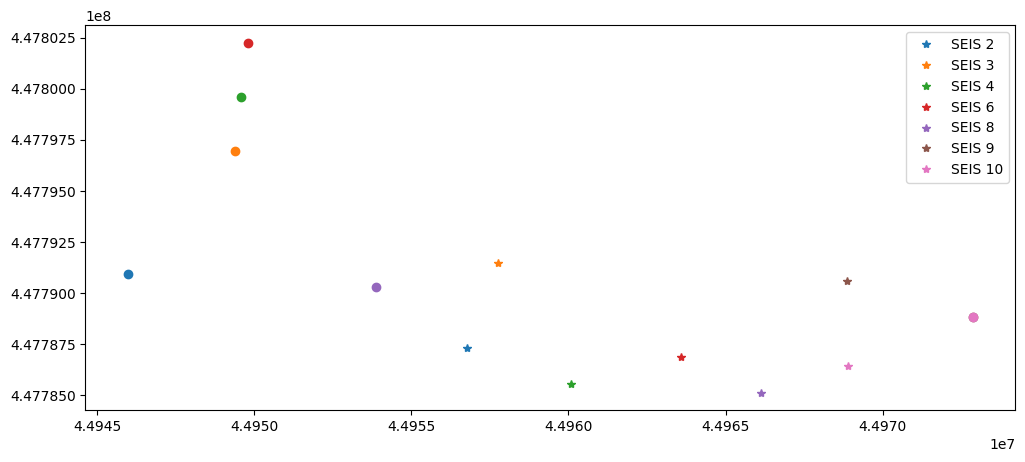

,id_via,nombre_via,id_via_cruzada,nombre_via_cruzada,tipo_via,x,y,speed,direccion_asociada,direccion_completa
31593,707600,CALLE SEIS,708700,AVENIDA SÉPTIMA,CALLE,44945972,447790938,5.555556,SEIS ,SEIS 2
31594,707600,CALLE SEIS,223450,CALLE CUATRO,CALLE,44949376,447796973,5.555556,SEIS ,SEIS 3
31595,707600,CALLE SEIS,753100,CALLE TRES,CALLE,44949575,447799602,5.555556,SEIS ,SEIS 3
31596,707600,CALLE SEIS,250700,CALLE DOS CIUDAD PEGASO,CALLE,44949791,447802257,5.555556,SEIS ,SEIS 3
31597,707600,CALLE SEIS,623200,AVENIDA QUINTA,CALLE,44953872,447790291,5.555556,SEIS ,SEIS 3
31598,707600,CALLE SEIS,706800,AVENIDA SEGUNDA,CALLE,44972882,447788836,5.555556,SEIS \t,SEIS 9
31599,707600,CALLE SEIS,760200,CALLE UNO,CALLE,44972882,447788836,5.555556,SEIS \t,SEIS 9


In [119]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
id_via=cruces.sample(1,random_state=4)["id_via"].values[0]
plt.plot()
for i,row in cruces[cruces["id_via"]==id_via].iterrows():
    plt.scatter(row["x"],row["y"])
for i,row in direcciones[direcciones["id_via"]==id_via].iterrows():
    plt.plot(row["x"],row["y"],"*",label=row["Direccion completa"])
plt.legend()
plt.show()
cruces[cruces["id_via"]==id_via]

### Create graph

In [120]:
g= Grafo(dirigido=False)
for _, cruce in cruces.drop_duplicates(["x", "y"]).iterrows():
    g.agregar_vertice((cruce["x"], cruce["y"]))

In [121]:
import itertools
def sort_tsp(df,start=None,end=None):
    '''
    1.finds the shortest path to visit all the nodes in df starting from start and ending in end
    2.Attaches the index for each node in the path
    3.Sorts the dataframe by the index
    '''
    
    best_distance=float("inf")
    best_path=None
    for path in itertools.permutations(df.index):
        distance=0
        for i in range(len(path)-1):
            distance+=(df.loc[path[i],"x"]-df.loc[path[i+1],"x"])**2+(df.loc[path[i],"y"]-df.loc[path[i+1],"y"])**2
        if start is not None:
            distance+=(df.loc[path[0],"x"]-start["x"])**2+(df.loc[path[0],"y"]-start["y"])**2
        if end is not None:
            distance+=(df.loc[path[-1],"x"]-end["x"])**2+(df.loc[path[-1],"y"]-end["y"])**2
        if distance<best_distance:
            best_distance=distance
            best_path=path
    # print(best_distance,best_path)
    # print("Best path",best_path)
    # df["index"]=best_path
    # df.sort_values("index",inplace=True)
    # print(df[["nombre_via","nombre_via_cruzada","direccion_completa"]])
    return best_path
sort_tsp(cruces[cruces["id_via"]==2465].copy())

(2215, 2216)

In [122]:
# order=[]
# for id_via,df in cruces.groupby("id_via"):
#     unique=df["direccion_asociada"].unique()
#     for i,(direccion,df2) in enumerate(df.groupby("direccion_asociada")):
#         if len(df2)>1:
#             start=None if i==0 else df[df["direccion_asociada"]==unique[i-1]].iloc[0]
#             end=None if i==len(unique)-1 else df[df["direccion_asociada"]==unique[i+1]].iloc[0]
#             order.extend(sort_tsp(df2.drop_duplicates(["x","y"]),start=start,end=end))
#         else:
#             order.append(df2.index[0])
#     print("Via:",id_via,"Cruces:",len(order))

In [137]:
order=[]
for id_via,df in cruces.groupby("id_via"):
    unique=df["direccion_asociada"].unique()
    for i,(direccion,df2) in enumerate(df.groupby("direccion_asociada")):
        if len(df2)>1:
            distance_matrix=np.zeros((len(df2),len(df2)))
            for j in range(len(df2)):
                for k in range(len(df2)):
                    distance_matrix[j,k]=(df2.iloc[j]["x"]-df2.iloc[k]["x"])**2+(df2.iloc[j]["y"]-df2.iloc[k]["y"])**2
            if len(df2)>7:
                order.extend(df2.index[tsp_greedy.solve_tsp(distance_matrix)])
            else:
                start=None if i==0 else df[df["direccion_asociada"]==unique[i-1]].iloc[0]
                end=None if i==len(unique)-1 else df[df["direccion_asociada"]==unique[i+1]].iloc[0]
                order.extend(sort_tsp(df2,start=start,end=end))
        else:
            order.append(df2.index[0])
    print("Via:",id_via,"Cruces:",len(order))

Via: 127 Cruces: 6
Via: 150 Cruces: 10
Via: 200 Cruces: 14
Via: 300 Cruces: 17
Via: 400 Cruces: 20
Via: 600 Cruces: 24
Via: 700 Cruces: 26
Via: 702 Cruces: 28
Via: 703 Cruces: 30
Via: 705 Cruces: 32
Via: 709 Cruces: 36
Via: 710 Cruces: 40
Via: 711 Cruces: 43
Via: 716 Cruces: 45
Via: 718 Cruces: 47
Via: 720 Cruces: 50
Via: 721 Cruces: 55
Via: 722 Cruces: 58
Via: 725 Cruces: 63
Via: 726 Cruces: 69
Via: 727 Cruces: 71
Via: 728 Cruces: 85
Via: 733 Cruces: 87
Via: 734 Cruces: 88
Via: 736 Cruces: 89
Via: 738 Cruces: 91
Via: 739 Cruces: 93
Via: 742 Cruces: 95
Via: 745 Cruces: 97
Via: 746 Cruces: 98
Via: 747 Cruces: 99
Via: 750 Cruces: 101
Via: 751 Cruces: 103
Via: 752 Cruces: 105
Via: 758 Cruces: 108
Via: 760 Cruces: 109
Via: 761 Cruces: 111
Via: 762 Cruces: 112
Via: 765 Cruces: 113
Via: 767 Cruces: 114
Via: 768 Cruces: 116
Via: 769 Cruces: 117
Via: 772 Cruces: 119
Via: 774 Cruces: 123
Via: 776 Cruces: 126
Via: 777 Cruces: 130
Via: 785 Cruces: 132
Via: 786 Cruces: 134
Via: 788 Cruces: 136
Via

In [138]:
len(cruces)==len(order)

True

In [139]:
cruces["order"]=order

In [140]:
for id_via,df in cruces.groupby("id_via"):
    df = df.sort_values(by="order")
    for i in range(df.shape[0]-1):
        r1 = df.iloc[i]
        r2 = df.iloc[i+1]
        if (r1["x"], r1["y"]) != (r2["x"], r2["y"]):
            v = r1["speed"]
            weight = np.round(np.sqrt((r1["x"]-r2["x"])**2+(r1["y"]-r2["y"])**2)/100/v) # tiempo en segundos
            weight = 1 if weight == 0 else weight
            g.agregar_arista(s=(r1["x"], r1["y"]), t=(r2["x"], r2["y"]), data=None, weight=weight)

In [141]:
len(g.aristas)

50286

In [142]:
g.save_graph("grafos/plano_de_madrid_tsp3.txt")